In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, GRU, Bidirectional, Conv3D, MaxPooling3D, Flatten, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
import scipy
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
ue_df = pd.read_csv(r'D:\TEEP\Onsite\internship\Code\UE_location\Data\UEReports.csv')
ue_df

,timestamp,Viavi.UE.Name,Viavi.UE.Slice,Viavi.Cell.Name,Viavi.Cell.beam,Viavi.mMIMO.Type,Viavi.mMIMO.Group,Viavi.mMIMO.Beamforming,Viavi.UE.Rsrp,Viavi.UE.Rsrq,...,RRU.PrbUsedUl,TB.TotNbrUl,DRB.UECqiDl,DRB.UEThpDl,RRU.PrbUsedDl,TB.TotNbrDl,Viavi.CA.cells,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,1721001600000,Indoor-1,eMBB,S1/N77/C2,1,SSB,1,Digital,-123.153442,-14.289001,...,0.0,0,0,0.000000,0.0,0,1,-84,-16,2
1,1721001600000,Indoor-2,eMBB,S2/N77/C1,1,SSB,1,Digital,-92.153442,-10.796079,...,0.0,0,0,0.000000,0.0,0,1,925,-14,12
2,1721001600000,UE-3,eMBB,S1/N77/C1,1,SSB,1,Digital,-95.153442,-10.800321,...,0.0,0,0,0.000000,0.0,0,1,39,173,2
3,1721001600000,UE-4,eMBB,S1/N77/C1,1,SSB,1,Digital,-100.153442,-10.818660,...,0.0,0,0,0.000000,0.0,0,1,189,-52,2
4,1721001600000,UE-5,eMBB,S2/N77/C1,1,SSB,1,Digital,-105.153442,-10.876151,...,0.0,0,0,0.000000,0.0,0,1,1039,173,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147195,1721260799000,UE-12,eMBB,S2/N77/C3,9,SSB,1,Digital,-70.153442,-10.791840,...,46.0,8142,15,0.045778,32.0,70639,1,1160,114,0
4147196,1721260799000,UE-13,eMBB,S2/N77/C3,9,SSB,1,Digital,-64.153442,-10.791820,...,45.0,6846,15,0.045778,32.0,59297,1,1140,149,0
4147197,1721260799000,UE-14,eMBB,S2/N77/C3,9,SSB,1,Digital,-99.153442,-10.813152,...,46.0,7270,13,0.039398,32.0,63156,1,1085,185,1
4147198,1721260799000,UE-15,eMBB,S2/N77/C3,9,SSB,1,Digital,-65.153442,-10.791821,...,45.0,6948,15,0.045778,32.0,61979,1,1145,148,0


In [3]:
ue_data = ue_df.copy()

In [4]:
ue_data = ue_data.drop(columns = ['Viavi.UE.Slice', 'Viavi.mMIMO.Type', 'Viavi.mMIMO.Group', 'Viavi.mMIMO.Beamforming', 'Viavi.UE.anomalies', 'Viavi.QoS.Priority', 'Viavi.QoS.5q', 
                                  'Viavi.CA.cells'])

In [5]:
ue_data['timestamp'] = pd.to_datetime(ue_data['timestamp'], unit='ms')
ue_data

,timestamp,Viavi.UE.Name,Viavi.Cell.Name,Viavi.Cell.beam,Viavi.UE.Rsrp,Viavi.UE.Rsrq,Viavi.UE.RsSinr,Viavi.UE.targetThroughputDl,Viavi.QoS.Score,DRB.UECqiUl,DRB.UEThpUl,RRU.PrbUsedUl,TB.TotNbrUl,DRB.UECqiDl,DRB.UEThpDl,RRU.PrbUsedDl,TB.TotNbrDl,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,2024-07-15 00:00:00,Indoor-1,S1/N77/C2,1,-123.153442,-14.289001,-0.924652,0.001,100,0,0.000000,0.0,0,0,0.000000,0.0,0,-84,-16,2
1,2024-07-15 00:00:00,Indoor-2,S2/N77/C1,1,-92.153442,-10.796079,30.075348,0.001,100,0,0.000000,0.0,0,0,0.000000,0.0,0,925,-14,12
2,2024-07-15 00:00:00,UE-3,S1/N77/C1,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
3,2024-07-15 00:00:00,UE-4,S1/N77/C1,1,-100.153442,-10.818660,22.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,189,-52,2
4,2024-07-15 00:00:00,UE-5,S2/N77/C1,1,-105.153442,-10.876151,17.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,1039,173,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147195,2024-07-17 23:59:59,UE-12,S2/N77/C3,9,-70.153442,-10.791840,52.075348,0.050,92,15,0.007322,46.0,8142,15,0.045778,32.0,70639,1160,114,0
4147196,2024-07-17 23:59:59,UE-13,S2/N77/C3,9,-64.153442,-10.791820,58.075348,0.050,92,15,0.007162,45.0,6846,15,0.045778,32.0,59297,1140,149,0
4147197,2024-07-17 23:59:59,UE-14,S2/N77/C3,9,-99.153442,-10.813152,23.075348,0.050,79,13,0.006299,46.0,7270,13,0.039398,32.0,63156,1085,185,1
4147198,2024-07-17 23:59:59,UE-15,S2/N77/C3,9,-65.153442,-10.791821,57.075348,0.050,92,15,0.007162,45.0,6948,15,0.045778,32.0,61979,1145,148,0


In [6]:
s1_data = ue_data[ue_data['Viavi.Cell.Name'].str.contains('S1')]
s1_data

,timestamp,Viavi.UE.Name,Viavi.Cell.Name,Viavi.Cell.beam,Viavi.UE.Rsrp,Viavi.UE.Rsrq,Viavi.UE.RsSinr,Viavi.UE.targetThroughputDl,Viavi.QoS.Score,DRB.UECqiUl,DRB.UEThpUl,RRU.PrbUsedUl,TB.TotNbrUl,DRB.UECqiDl,DRB.UEThpDl,RRU.PrbUsedDl,TB.TotNbrDl,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,2024-07-15 00:00:00,Indoor-1,S1/N77/C2,1,-123.153442,-14.289001,-0.924652,0.001,100,0,0.000000,0.0,0,0,0.000000,0.0,0,-84,-16,2
2,2024-07-15 00:00:00,UE-3,S1/N77/C1,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
3,2024-07-15 00:00:00,UE-4,S1/N77/C1,1,-100.153442,-10.818660,22.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,189,-52,2
6,2024-07-15 00:00:00,UE-7,S1/N77/C1,1,-95.153442,-10.800321,27.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,39,173,2
7,2024-07-15 00:00:00,UE-8,S1/N77/C1,1,-106.153442,-10.897724,16.075348,0.010,100,0,0.000000,0.0,0,0,0.000000,0.0,0,73,164,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147190,2024-07-17 23:59:59,UE-7,S1/N77/C2,3,-66.153442,-10.791823,56.075348,0.050,92,15,0.021805,137.0,8076,15,0.045778,32.0,71079,140,54,0
4147191,2024-07-17 23:59:59,UE-8,S1/N77/C3,9,-59.153439,-10.791815,63.075348,0.050,92,15,0.008752,55.0,6916,15,0.045778,32.0,61051,100,149,0
4147192,2024-07-17 23:59:59,UE-9,S1/N77/C3,9,-95.153442,-10.800321,27.075348,0.050,92,15,0.008594,54.0,6992,15,0.045778,32.0,61498,89,181,1
4147193,2024-07-17 23:59:59,UE-10,S1/N77/C3,9,-69.153442,-10.791834,53.075348,0.050,92,15,0.008752,55.0,7004,15,0.045778,32.0,62861,105,145,0


In [7]:
s1_data = s1_data.drop(columns = ['Viavi.Cell.Name'])

In [8]:
ue_list = s1_data['Viavi.UE.Name'].unique()

In [9]:
s1_data_matter = s1_data[['timestamp', 'DRB.UEThpUl', 'RRU.PrbUsedUl', 'Viavi.UE.RsSinr', 'Viavi.UE.Name', 'Viavi.Cell.beam', 'Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z']]

In [10]:
s1_data_matter

,timestamp,DRB.UEThpUl,RRU.PrbUsedUl,Viavi.UE.RsSinr,Viavi.UE.Name,Viavi.Cell.beam,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,2024-07-15 00:00:00,0.000000,0.0,-0.924652,Indoor-1,1,-84,-16,2
2,2024-07-15 00:00:00,0.000000,0.0,27.075348,UE-3,1,39,173,2
3,2024-07-15 00:00:00,0.000000,0.0,22.075348,UE-4,1,189,-52,2
6,2024-07-15 00:00:00,0.000000,0.0,27.075348,UE-7,1,39,173,2
7,2024-07-15 00:00:00,0.000000,0.0,16.075348,UE-8,1,73,164,2
...,...,...,...,...,...,...,...,...,...
4147190,2024-07-17 23:59:59,0.021805,137.0,56.075348,UE-7,3,140,54,0
4147191,2024-07-17 23:59:59,0.008752,55.0,63.075348,UE-8,9,100,149,0
4147192,2024-07-17 23:59:59,0.008594,54.0,27.075348,UE-9,9,89,181,1
4147193,2024-07-17 23:59:59,0.008752,55.0,53.075348,UE-10,9,105,145,0


In [14]:
def create_sequences(data, target_data, sequence_length=10):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = target_data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

def standardize_data(data, isoutput, train_df):
    column_output=['Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z']
    if isoutput:
        mean = train_df[column_output].mean().values
        std = train_df[column_output].std().values
    else:
        mean = train_df.mean().values
        std = train_df.std().values

    # Reshape for broadcasting with 2D matrix
    mean = mean.reshape(1, -1)
    std = std.reshape(1, -1)

    return (data - mean) / std

def inverse_standardize_data(data, isoutput, train_df):
    column_output=['Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z']
    if isoutput:
        mean = train_df[column_output].mean().values
        std = train_df[column_output].std().values
    else:
        mean = train_df.mean().values
        std = train_df.std().values

    # Reshape for broadcasting with 2D matrix
    mean = mean.reshape(1, -1)
    std = std.reshape(1, -1)

    return (data * std) + mean

def plot_predictions(df_predictions, user_id):
    df_user = df_predictions
    plt.figure(figsize=(12, 8))
    
    plt.plot(df_user.index, df_user['actual_x'], label='Actual x', color='blue')
    plt.plot(df_user.index, df_user['predicted_x'], label='Predicted x', color='red', linestyle='--')
    
    plt.plot(df_user.index, df_user['actual_y'], label='Actual y', color='green')
    plt.plot(df_user.index, df_user['predicted_y'], label='Predicted y', color='orange', linestyle='--')
    
    plt.plot(df_user.index, df_user['actual_z'], label='Actual z', color='purple')
    plt.plot(df_user.index, df_user['predicted_z'], label='Predicted z', color='brown', linestyle='--')
    
    plt.xlabel('Index')
    plt.ylabel('Location Coordinates')
    plt.title(f'Actual vs Predicted Locations for User {user_id}')
    plt.legend()
    plt.grid(True)
    plt.show()

def display_predictions(predictions, actual_values):
    df = pd.DataFrame({
        'predicted_x': predictions[:, 0],
        'predicted_y': predictions[:, 1],
        'predicted_z': predictions[:, 2],
        'actual_x': actual_values[:, 0],
        'actual_y': actual_values[:, 1],
        'actual_z': actual_values[:, 2]
    })
    return df

def preprocessing_data(data, ue_id):
    new_data = data[data['Viavi.UE.Name'] == ue_id]

    train_df = new_data[new_data['timestamp'] < '2024-07-17 00:00:00'].drop(columns = ['timestamp', 'Viavi.UE.Name'])
    test_time_df = new_data[new_data['timestamp'].dt.date == pd.to_datetime('2024-07-17').date()].set_index('timestamp').between_time('14:00', '15:00').reset_index().drop(columns = ['timestamp', 'Viavi.UE.Name'])
    
    train_df_scaled = standardize_data(train_df, False, train_df)
    test_df_scaled = standardize_data(test_time_df, False, train_df)
    
    X_train, y_train = create_sequences(train_df_scaled.values, train_df_scaled[['Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z']].values)
    X_test, y_test = create_sequences(test_df_scaled.values, test_df_scaled[['Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z']].values)
    print("X train shape: ", X_train.shape)
    print("y train shape: ", y_train.shape)
    print("X test shape: ", X_test.shape)
    print("y test shape: ", y_test.shape)

    return X_train, y_train, X_test, y_test, train_df

def transfer_learning(data, ue_id):
    X_train, y_train, X_test, y_test, train_df = preprocessing_data(data, ue_id)

    model = load_model("transfer_UE_model.h5")
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=10, batch_size = 64, validation_split=0.2, callbacks=[early_stopping])

    predictions = model.predict(X_test)

    predictions_inverse = inverse_standardize_data(predictions, True, train_df)
    y_inverse = inverse_standardize_data(y_test, True, train_df)

    rmse = np.sqrt(mean_squared_error(y_inverse, predictions_inverse))
    print('Test RMSE: ', rmse)

    df_predictions = display_predictions(predictions_inverse, y_inverse)
    print(df_predictions.head())

    plt.figure(figsize=(10, 6))
    plt.scatter(df_predictions['predicted_x'], df_predictions['predicted_y'], label='Predicted', color='blue')
    plt.scatter(df_predictions['actual_x'], df_predictions['actual_y'], label='Actual', color='red')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('XY Coordinate Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

In [11]:
s1_ue_7 = s1_data_matter[s1_data_matter['Viavi.UE.Name'] == ue_list[3]]
s1_ue_7

,timestamp,DRB.UEThpUl,RRU.PrbUsedUl,Viavi.UE.RsSinr,Viavi.UE.Name,Viavi.Cell.beam,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
6,2024-07-15 00:00:00,0.000000,0.0,27.075348,UE-7,1,39,173,2
22,2024-07-15 00:00:01,0.003436,39.0,56.075348,UE-7,1,39,172,1
38,2024-07-15 00:00:02,0.003816,46.0,35.075348,UE-7,1,39,172,1
54,2024-07-15 00:00:03,0.007322,46.0,35.075348,UE-7,1,39,172,1
70,2024-07-15 00:00:04,0.007322,46.0,35.075348,UE-7,9,39,172,1
...,...,...,...,...,...,...,...,...,...
4147126,2024-07-17 23:59:55,0.021805,137.0,56.075348,UE-7,3,140,54,0
4147142,2024-07-17 23:59:56,0.021805,137.0,56.075348,UE-7,3,140,54,0
4147158,2024-07-17 23:59:57,0.021805,137.0,56.075348,UE-7,3,140,54,0
4147174,2024-07-17 23:59:58,0.021805,137.0,56.075348,UE-7,3,140,54,0


In [28]:
train_df = s1_ue_7[s1_ue_7['timestamp'] < '2024-07-17 00:00:00'].drop(columns = ['timestamp', 'Viavi.UE.Name'])
test_time_df = s1_ue_7[s1_ue_7['timestamp'].dt.date == pd.to_datetime('2024-07-17').date()].set_index('timestamp').between_time('14:00', '15:00').reset_index().drop(columns = ['timestamp', 'Viavi.UE.Name'])

In [18]:
# train_df.to_csv('train_df.csv', index=False)
# test_time_df.to_csv('test_df.csv', index=False)

In [15]:
train_df_scaled = standardize_data(train_df, False, train_df)
test_df_scaled = standardize_data(test_time_df, False, train_df)

In [19]:
train_df_scaled

,DRB.UEThpUl,RRU.PrbUsedUl,Viavi.UE.RsSinr,Viavi.Cell.beam,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
6,-2.599273,-2.608222,-2.630041,-1.436917,-2.216555,1.362168,5.573289
22,-1.747824,-1.067522,-0.014940,-1.436917,-2.216555,1.351111,2.594248
38,-1.653659,-0.790986,-1.908634,-1.436917,-2.216555,1.351111,2.594248
54,-0.784964,-0.790986,-1.908634,-1.436917,-2.216555,1.351111,2.594248
70,-0.784964,-0.790986,-1.908634,1.204139,-2.216555,1.351111,2.594248
...,...,...,...,...,...,...,...
2764726,-1.038317,-0.790986,-2.990745,1.204139,-0.953082,1.483799,2.594248
2764742,-1.038317,-0.790986,-2.990745,1.204139,-0.953082,1.483799,2.594248
2764758,-1.038317,-0.790986,-2.990745,1.204139,-0.953082,1.483799,2.594248
2764774,-1.038317,-0.790986,-2.990745,1.204139,-0.953082,1.483799,2.594248


In [20]:
test_df_scaled

,DRB.UEThpUl,RRU.PrbUsedUl,Viavi.UE.RsSinr,Viavi.Cell.beam,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,-0.430508,-0.435439,-2.449689,1.204139,-3.901185,1.129965,2.594248
1,-0.430508,-0.435439,-2.449689,1.204139,-3.901185,1.129965,2.594248
2,-0.430508,-0.435439,-1.998810,1.204139,-3.927508,1.129965,2.594248
3,-0.430508,-0.435439,-1.998810,1.204139,-3.927508,1.129965,2.594248
4,-0.430508,-0.435439,-1.998810,1.204139,-3.927508,1.129965,2.594248
...,...,...,...,...,...,...,...
3596,-0.430508,-0.435439,0.255588,-0.776653,0.442002,-0.362774,-0.384793
3597,-0.430508,-0.435439,0.255588,-0.776653,0.442002,-0.362774,-0.384793
3598,-0.430508,-0.435439,0.255588,-0.776653,0.442002,-0.373831,-0.384793
3599,-0.430508,-0.435439,0.075236,-0.776653,0.442002,-0.373831,-0.384793


In [32]:
merged_df = pd.concat([train_df, test_time_df], ignore_index=True)
merged_df

,DRB.UEThpUl,RRU.PrbUsedUl,Viavi.UE.RsSinr,Viavi.Cell.beam,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
0,0.000000,0.0,27.075348,1,39,173,2
1,0.003436,39.0,56.075348,1,39,172,1
2,0.003816,46.0,35.075348,1,39,172,1
3,0.007322,46.0,35.075348,1,39,172,1
4,0.007322,46.0,35.075348,9,39,172,1
...,...,...,...,...,...,...,...
176396,0.008752,55.0,59.075348,3,140,17,0
176397,0.008752,55.0,59.075348,3,140,17,0
176398,0.008752,55.0,59.075348,3,140,16,0
176399,0.008752,55.0,57.075348,3,140,16,0


In [30]:
merged_df.to_csv('Data/merged_df.csv', index=False)

In [34]:
merged_df.iloc[172800:172800+3601]

,DRB.UEThpUl,RRU.PrbUsedUl,Viavi.UE.RsSinr,Viavi.Cell.beam,Viavi.Geo.x,Viavi.Geo.y,Viavi.Geo.z
172800,0.008752,55.0,29.075348,9,-25,152,1
172801,0.008752,55.0,29.075348,9,-25,152,1
172802,0.008752,55.0,34.075348,9,-26,152,1
172803,0.008752,55.0,34.075348,9,-26,152,1
172804,0.008752,55.0,34.075348,9,-26,152,1
...,...,...,...,...,...,...,...
176396,0.008752,55.0,59.075348,3,140,17,0
176397,0.008752,55.0,59.075348,3,140,17,0
176398,0.008752,55.0,59.075348,3,140,16,0
176399,0.008752,55.0,57.075348,3,140,16,0


In [26]:
merged_df.columns

Index(['DRB.UEThpUl', 'RRU.PrbUsedUl', 'Viavi.UE.RsSinr', 'Viavi.Cell.beam',
       'Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z'],
      dtype='object')

In [15]:
X_train, y_train = create_sequences(train_df_scaled.values, train_df_scaled[['Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z']].values)
X_test, y_test = create_sequences(test_df_scaled.values, test_df_scaled[['Viavi.Geo.x', 'Viavi.Geo.y', 'Viavi.Geo.z']].values)

In [16]:
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)


In [17]:
seq_length = 10
model = Sequential()
model.add(LSTM(120, return_sequences=True, input_shape=(seq_length, 7)))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'linear'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size = 64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
2160/2160 [==============================] - 105s 47ms/step - loss: 0.0416 - val_loss: 0.0076
Epoch 2/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0199 - val_loss: 0.0064
Epoch 3/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0179 - val_loss: 0.0057
Epoch 4/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0170 - val_loss: 0.0047
Epoch 5/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0164 - val_loss: 0.0044
Epoch 6/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0157 - val_loss: 0.0035
Epoch 7/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0151 - val_loss: 0.0035
Epoch 8/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0148 - val_loss: 0.0033
Epoch 9/10
2160/2160 [==============================] - 101s 47ms/step - loss: 0.0145 - val_loss: 0.0032
Epoch 10/10
2160/2160 [==============================] 

In [26]:
model.save("transfer_UE_model.h5")

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
predictions = model.predict(X_test)

113/113 [==============================] - 2s 10ms/step


In [20]:
predictions_inverse = inverse_standardize_data(predictions, True, train_df)
y_inverse = inverse_standardize_data(y_test, True, train_df)

In [21]:
rmse = np.sqrt(mean_squared_error(y_inverse, predictions_inverse))
print('Test RMSE: ', rmse)

Test RMSE:  4.244389998182254


In [22]:
df_predictions = display_predictions(predictions_inverse, y_inverse)
print(df_predictions.head())

   predicted_x  predicted_y  predicted_z  actual_x  actual_y  actual_z
0   -33.668057   162.830238     1.003820     -26.0     152.0       1.0
1   -33.637188   162.656502     1.003578     -26.0     152.0       1.0
2   -33.620921   162.608904     1.003380     -26.0     152.0       1.0
3   -33.620921   162.608904     1.003380     -26.0     152.0       1.0
4   -33.620921   162.608904     1.003380     -26.0     152.0       1.0


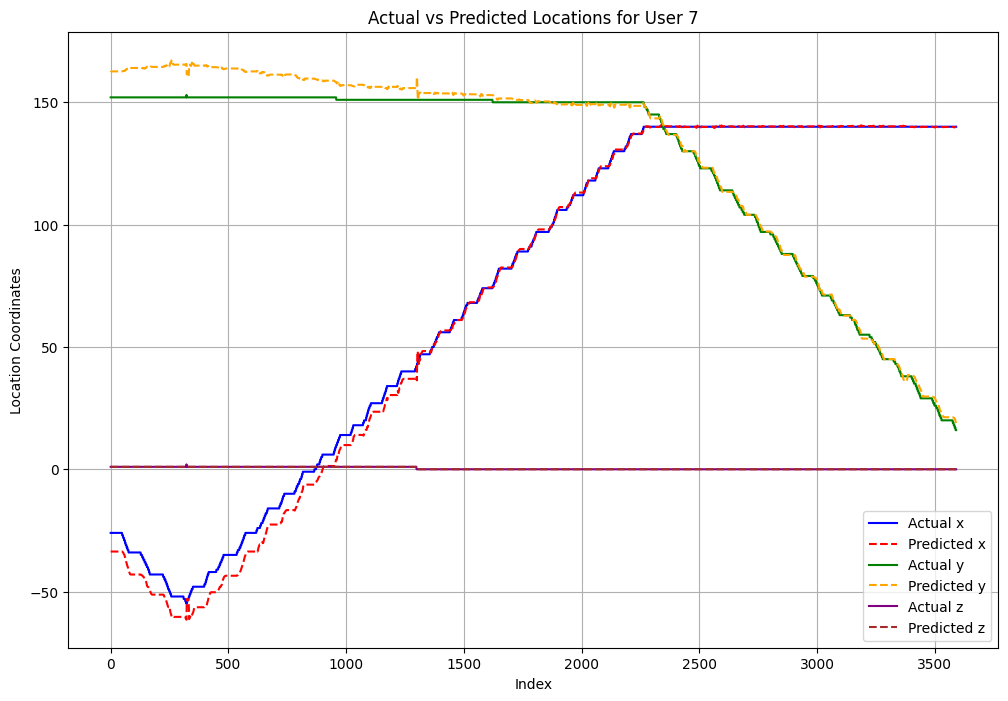

In [23]:
plot_predictions(df_predictions, 7)

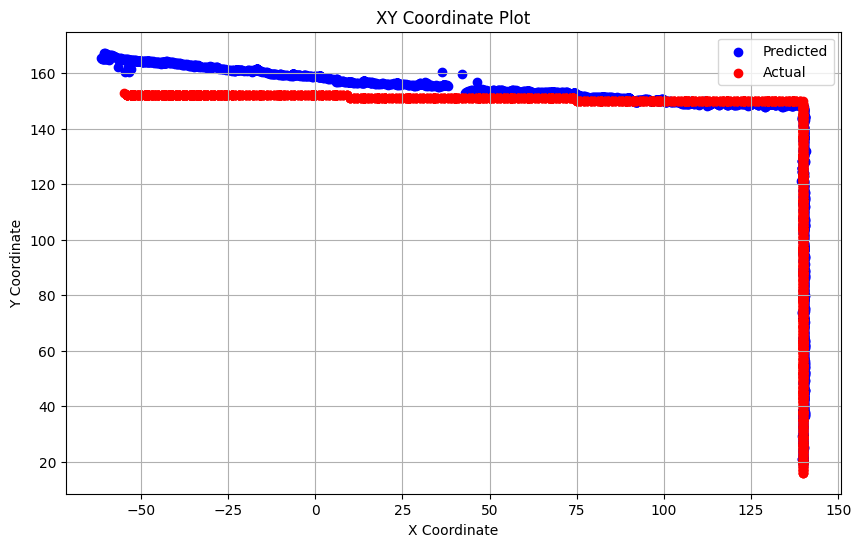

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(df_predictions['predicted_x'], df_predictions['predicted_y'], label='Predicted', color='blue')
plt.scatter(df_predictions['actual_x'], df_predictions['actual_y'], label='Actual', color='red')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('XY Coordinate Plot')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
ue_list = np.delete(ue_list, 3)
ue_list

array(['Indoor-1', 'UE-3', 'UE-4', 'UE-8', 'UE-9', 'UE-10', 'UE-11'],
      dtype=object)

UE Name: Indoor-1
X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)
Epoch 1/10
2160/2160 [==============================] - 108s 48ms/step - loss: 0.0169 - val_loss: 0.0927
Epoch 2/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0128 - val_loss: 0.0700
Epoch 3/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0120 - val_loss: 0.0770
Epoch 4/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0116 - val_loss: 0.0906
Epoch 5/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0113 - val_loss: 0.1033
Epoch 6/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0112 - val_loss: 0.1164
Epoch 7/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0111 - val_loss: 0.1363
Epoch 8/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0110 - val_loss: 0.1464
Epoch 9/10
2160/2160 [======

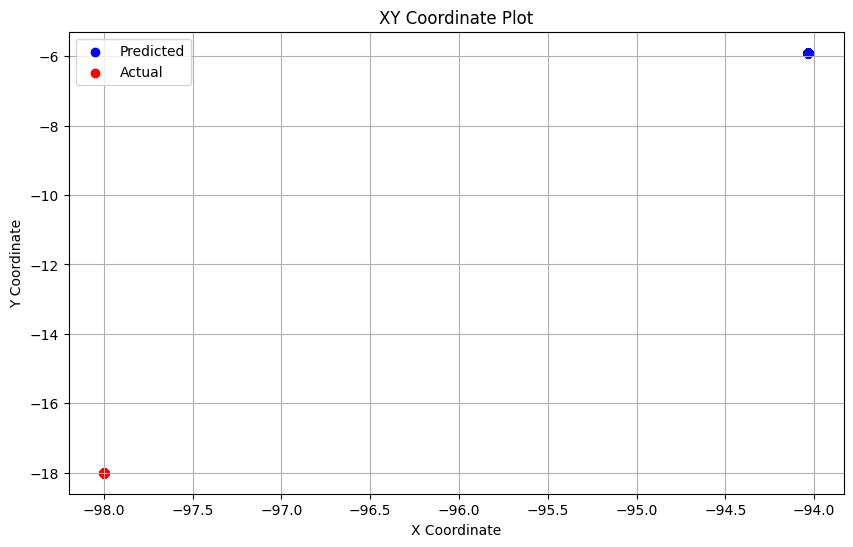



UE Name: UE-3
X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)
Epoch 1/10
2160/2160 [==============================] - 109s 48ms/step - loss: 0.0236 - val_loss: 0.0178
Epoch 2/10
2160/2160 [==============================] - 103s 47ms/step - loss: 0.0186 - val_loss: 0.0167
Epoch 3/10
2160/2160 [==============================] - 103s 48ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 4/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0168 - val_loss: 0.0138
Epoch 5/10
2160/2160 [==============================] - 103s 47ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 6/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0160 - val_loss: 0.0151
Epoch 7/10
2160/2160 [==============================] - 102s 47ms/step - loss: 0.0158 - val_loss: 0.0164
Epoch 8/10
2160/2160 [==============================] - 103s 47ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 9/10
2160/2160 [========

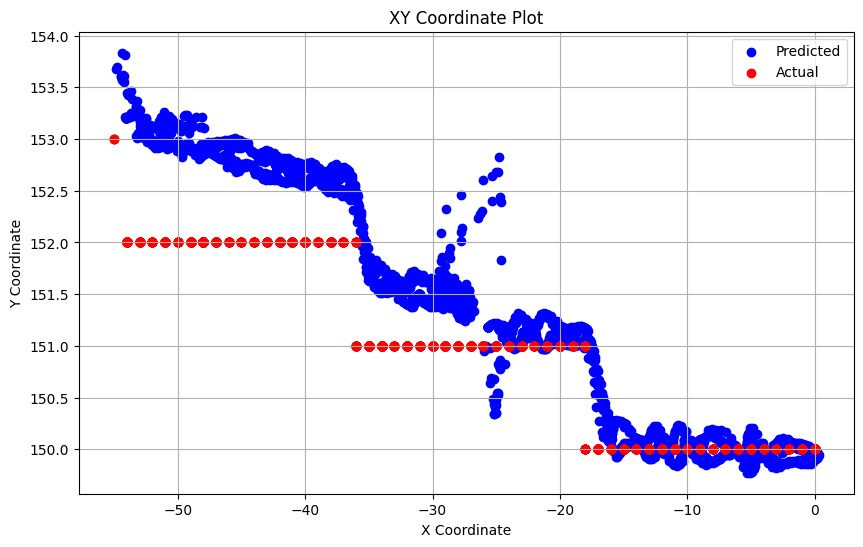



UE Name: UE-4
X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)
Epoch 1/10
2160/2160 [==============================] - 108s 48ms/step - loss: 0.0233 - val_loss: 0.0101
Epoch 2/10
2160/2160 [==============================] - 105s 49ms/step - loss: 0.0179 - val_loss: 0.0093
Epoch 3/10
2160/2160 [==============================] - 105s 49ms/step - loss: 0.0169 - val_loss: 0.0099
Epoch 4/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0164 - val_loss: 0.0103
Epoch 5/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0158 - val_loss: 0.0108
Epoch 6/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0155 - val_loss: 0.0136
Epoch 7/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0153 - val_loss: 0.0116
Epoch 8/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0151 - val_loss: 0.0107
Epoch 9/10
2160/2160 [========

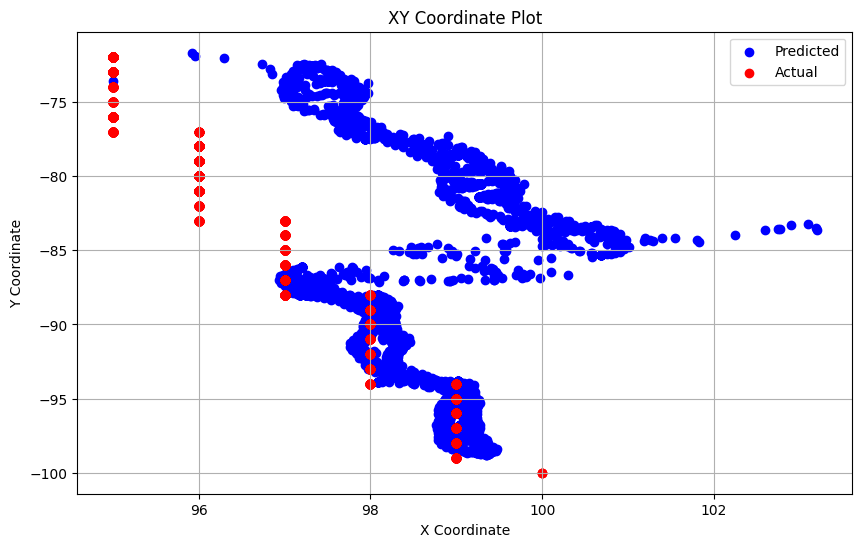



UE Name: UE-8
X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)
Epoch 1/10
2160/2160 [==============================] - 111s 49ms/step - loss: 0.0144 - val_loss: 0.0028
Epoch 2/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0141 - val_loss: 0.0024
Epoch 3/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0139 - val_loss: 0.0021
Epoch 4/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0138 - val_loss: 0.0023
Epoch 5/10
2160/2160 [==============================] - 105s 48ms/step - loss: 0.0137 - val_loss: 0.0020
Epoch 6/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0137 - val_loss: 0.0020
Epoch 7/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0136 - val_loss: 0.0025
Epoch 8/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0135 - val_loss: 0.0021
Epoch 9/10
2160/2160 [========

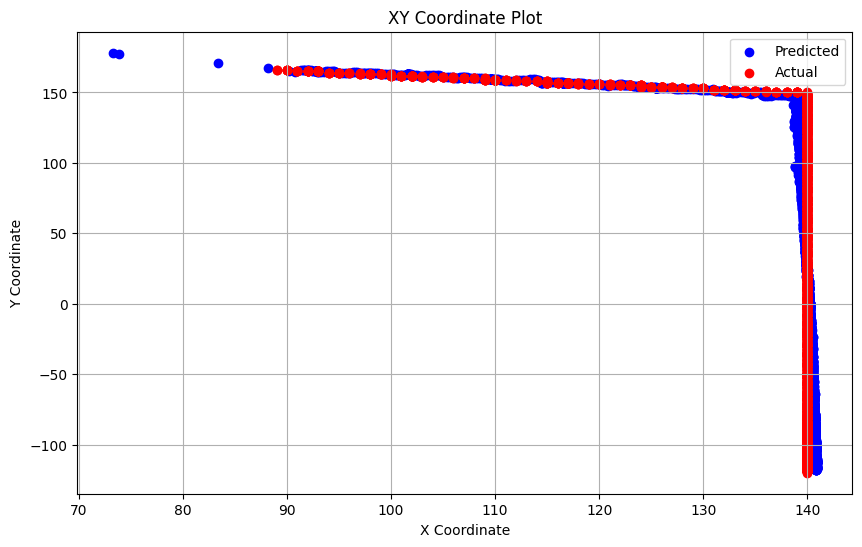



UE Name: UE-9
X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)
Epoch 1/10
2160/2160 [==============================] - 109s 48ms/step - loss: 0.0147 - val_loss: 0.0090
Epoch 2/10
2160/2160 [==============================] - 103s 48ms/step - loss: 0.0144 - val_loss: 0.0096
Epoch 3/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0143 - val_loss: 0.0094
Epoch 4/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0141 - val_loss: 0.0092
Epoch 5/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0140 - val_loss: 0.0095
Epoch 6/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0138 - val_loss: 0.0092
Epoch 7/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0137 - val_loss: 0.0090
Epoch 8/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0137 - val_loss: 0.0097
Epoch 9/10
2160/2160 [========

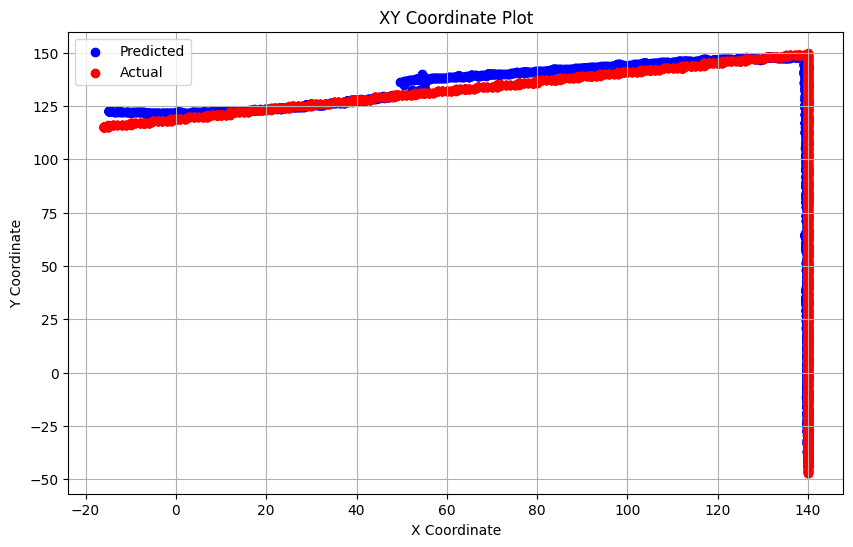



UE Name: UE-10
X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)
Epoch 1/10
2160/2160 [==============================] - 109s 48ms/step - loss: 0.0146 - val_loss: 0.0024
Epoch 2/10
2160/2160 [==============================] - 106s 49ms/step - loss: 0.0143 - val_loss: 0.0026
Epoch 3/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0141 - val_loss: 0.0021
Epoch 4/10
2160/2160 [==============================] - 105s 49ms/step - loss: 0.0139 - val_loss: 0.0021
Epoch 5/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0139 - val_loss: 0.0022
Epoch 6/10
2160/2160 [==============================] - 103s 48ms/step - loss: 0.0136 - val_loss: 0.0021
Epoch 7/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0136 - val_loss: 0.0022
Epoch 8/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0136 - val_loss: 0.0022
Epoch 9/10
2160/2160 [=======

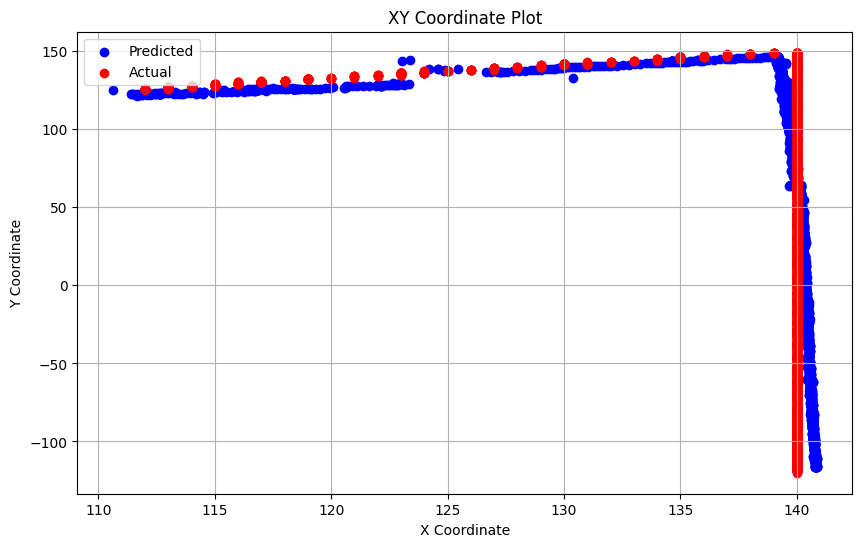



UE Name: UE-11
X train shape:  (172790, 10, 7)
y train shape:  (172790, 3)
X test shape:  (3591, 10, 7)
y test shape:  (3591, 3)
Epoch 1/10
2160/2160 [==============================] - 112s 50ms/step - loss: 0.0144 - val_loss: 0.0063
Epoch 2/10
2160/2160 [==============================] - 105s 48ms/step - loss: 0.0142 - val_loss: 0.0068
Epoch 3/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0141 - val_loss: 0.0074
Epoch 4/10
2160/2160 [==============================] - 105s 48ms/step - loss: 0.0139 - val_loss: 0.0066
Epoch 5/10
2160/2160 [==============================] - 105s 48ms/step - loss: 0.0137 - val_loss: 0.0064
Epoch 6/10
2160/2160 [==============================] - 105s 49ms/step - loss: 0.0136 - val_loss: 0.0074
Epoch 7/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0136 - val_loss: 0.0070
Epoch 8/10
2160/2160 [==============================] - 104s 48ms/step - loss: 0.0135 - val_loss: 0.0070
Epoch 9/10
2160/2160 [=======

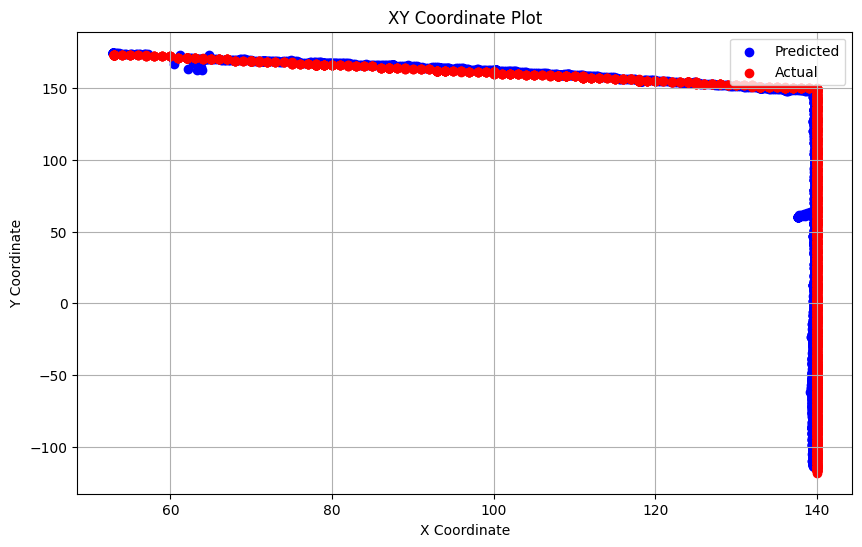

In [38]:
for ue in ue_list:
    print(f"UE Name: {ue}")
    model_transfer = transfer_learning(s1_data_matter, ue)
    print()
    print()

In [40]:
model_transfer.save("transfer_result.h5")

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 1s 10ms/step
Test RMSE:  4.846770037685825
   predicted_x  predicted_y  predicted_z  actual_x  actual_y  actual_z
0   -33.668057   162.830238     1.003820     -26.0     152.0       1.0
1   -33.637188   162.656502     1.003578     -26.0     152.0       1.0
2   -33.620921   162.608904     1.003380     -26.0     152.0       1.0
3   -33.620921   162.608904     1.003380     -26.0     152.0       1.0
4   -33.620921   162.608904     1.003380     -26.0     152.0       1.0


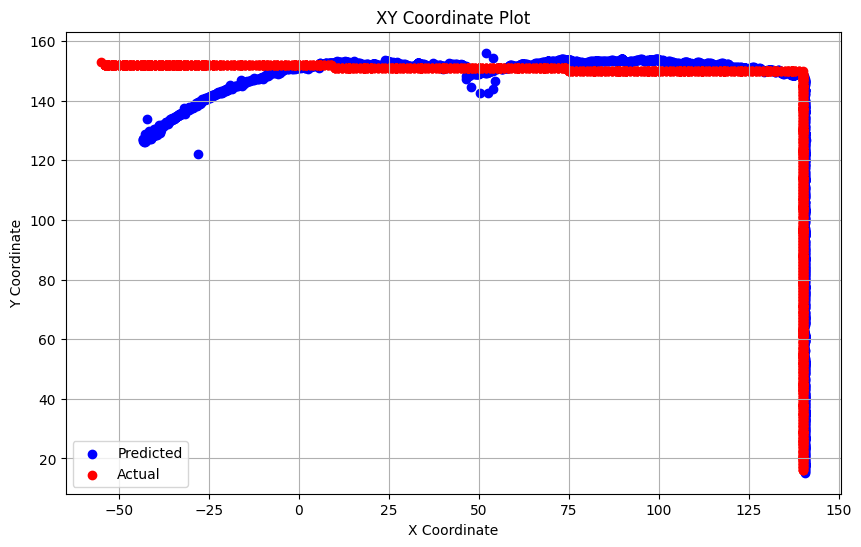

In [41]:
prediction_transfer = model_transfer.predict(X_test)

prediction_transfer_inverse = inverse_standardize_data(prediction_transfer, True, train_df)
# y_inverse = inverse_standardize_data(y_test, True, train_df)

rmse = np.sqrt(mean_squared_error(y_inverse, prediction_transfer_inverse))
print('Test RMSE: ', rmse)

df_predictions_transfer = display_predictions(prediction_transfer_inverse, y_inverse)
print(df_predictions.head())

plt.figure(figsize=(10, 6))
plt.scatter(df_predictions_transfer['predicted_x'], df_predictions_transfer['predicted_y'], label='Predicted', color='blue')
plt.scatter(df_predictions_transfer['actual_x'], df_predictions_transfer['actual_y'], label='Actual', color='red')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('XY Coordinate Plot')
plt.legend()
plt.grid(True)
plt.show()